# Requirements

In [2]:
import os

import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset
import cv2

import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import albumentations as A

/Users/len/anaconda3/envs/py_projects/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/len/anaconda3/envs/py_projects/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <A0E0B741-848C-3144-924F-2971884DA4EF> /Users/len/anaconda3/envs/py_projects/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <6384E44A-E10D-30C9-994F-E34B0519E5B3> /Users/len/anaconda3/envs/py_projects/lib/python3.10/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


# Data

In [63]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, paths, transforms = None, padding = None):
        super().__init__()
        self.paths = paths
        self.transforms = transforms
        self.pad = padding
        
    def __len__(self):
        return len(self.paths)
        
    def __getitem__(self, ind):
        
        img = cv2.imread(paths[ind])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if self.pad != None:
            img = self.pad(image = img)['image']
            
        if self.transforms != None:
            img = self.transforms(img)
        
        return img

In [44]:
root_dir = 'naruto-face-dataset'

In [45]:
paths = []

In [46]:
for folder in os.listdir(root_dir):
    if folder == '.DS_Store' or folder == '.ipynb_checkpoints':
        continue
    folder_path = os.path.join(root_dir, folder)
    for file in os.listdir(folder_path):
        if file == '.DS_Store' or file == '.ipynb_checkpoints':
            continue
        paths.append(os.path.join(folder_path, file))

In [47]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

In [64]:
dataset = Dataset(paths, train_transforms, pad)

Show some samples from dataset

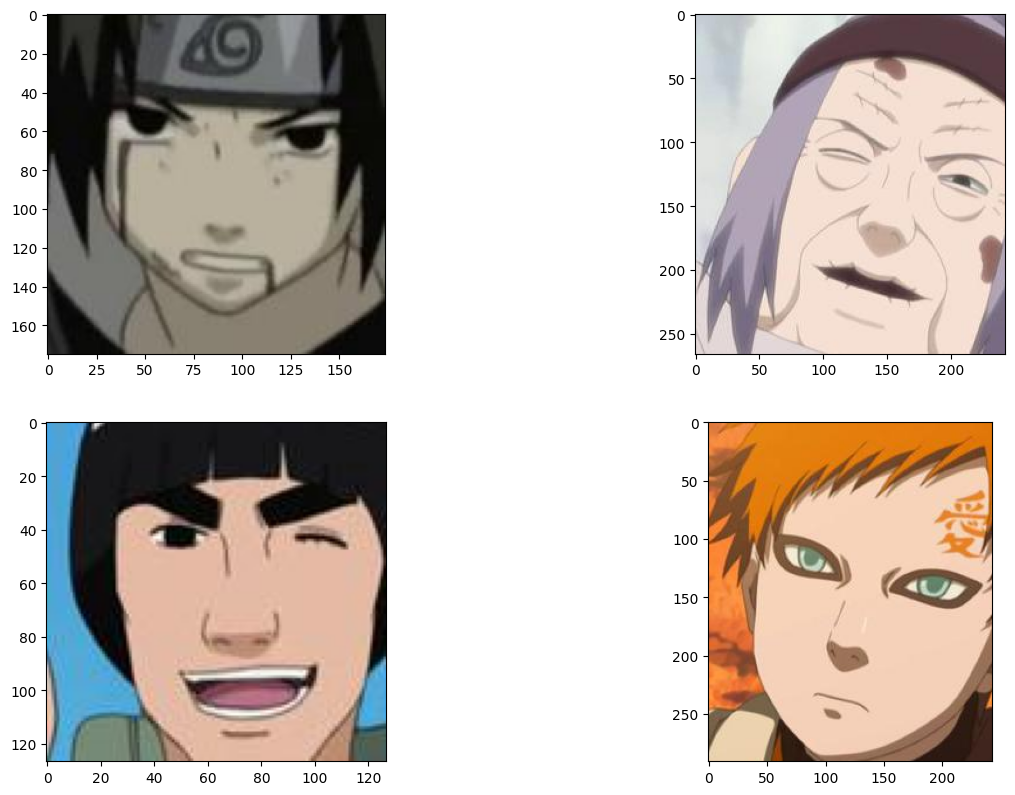

In [19]:
plt.figure(figsize=(15,15))
for i in range(n_samples):
    img = dataset[i]
    plt.subplot(n_samples//cols + 1, cols, i + 1)
    plt.imshow(img)

# Data Processing

In [171]:
image_size = 128 
transforms = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Resize(size = (image_size, image_size)),
    ])
pad = A.Compose([
    A.PadIfNeeded(image_size, image_size, value = 0)
])

In [180]:
transformed_dataset = Dataset(paths, transforms, pad)

# Model

In [3]:
class AE(nn.Module):
    
    
    def __init__(self, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim

        self.encoder =  nn.Sequential(
            nn.Conv2d(3, 32, kernel_size = 3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, kernel_size = 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, kernel_size = 3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Conv2d(128, 256, kernel_size = 3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.Conv2d(256, 512, kernel_size = 3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),
            nn.Conv2d(512, 512, kernel_size = 3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU()
        )

        self.decoder = nn.Sequential(
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.ConvTranspose2d(512, 512, 3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.ConvTranspose2d(512, 256, 3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.ConvTranspose2d(256, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.ConvTranspose2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.ConvTranspose2d(64, 32, 3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.ConvTranspose2d(32, 3, 3, stride=1, padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        z = self.encoder(x)
        z = self.decoder(x)
        return z

In [4]:
model = AE(512)

In [121]:
def train_epoch(model, dataloader, optimizer, loss_fn, device):
    model.to(device)
    model.train()

    total_loss = 0.0
    for batch in tqdm(dataloader):
        optimizer.zero_grad()

        images = batch.to(device)
        rec_images = model(images)
        
        loss = loss_fn(rec_images, images)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    return total_loss / len(dataloader.dataset)

In [182]:
loss_fn = torch.nn.functional.mse_loss
model = AE(512)
dataloader = torch.utils.data.DataLoader(transformed_dataset,
                                        batch_size = 8,
                                        shuffle = True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
device = 'mps'

In [183]:
epochs = 10

In [184]:
train_losses = []

In [198]:
for epoch_i in range(epochs):
    train_loss = train_epoch(model, dataloader, optimizer, loss_fn, device)
    train_losses.append(train_loss)
    print(f'Epoch: {epoch_i} Train_loss: {train_loss}')

  0%|          | 0/883 [00:00<?, ?it/s]

Epoch: 0 Train_loss: 0.0008536313697526808


  0%|          | 0/883 [00:00<?, ?it/s]

Epoch: 1 Train_loss: 0.0008319051782126144


  0%|          | 0/883 [00:00<?, ?it/s]

Epoch: 2 Train_loss: 0.000826166857792012


  0%|          | 0/883 [00:00<?, ?it/s]

Epoch: 3 Train_loss: 0.0008160988378908765


  0%|          | 0/883 [00:00<?, ?it/s]

Epoch: 4 Train_loss: 0.0008249685779096186


  0%|          | 0/883 [00:00<?, ?it/s]

Epoch: 5 Train_loss: 0.0007667476560092224


  0%|          | 0/883 [00:00<?, ?it/s]

Epoch: 6 Train_loss: 0.000752102195089811


  0%|          | 0/883 [00:00<?, ?it/s]

Epoch: 7 Train_loss: 0.0007463229854576806


  0%|          | 0/883 [00:00<?, ?it/s]

Epoch: 8 Train_loss: 0.0007462628688296363


  0%|          | 0/883 [00:00<?, ?it/s]

Epoch: 9 Train_loss: 0.0007274003866497748


In [195]:
model.eval()
with torch.no_grad():
    rec_images = model(transformed_dataset[0].unsqueeze(0).to('mps'))

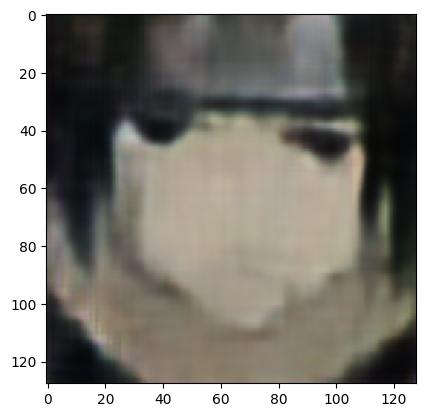

In [196]:
plt.imshow(rec_images[0].permute(1, 2, 0).cpu().numpy())

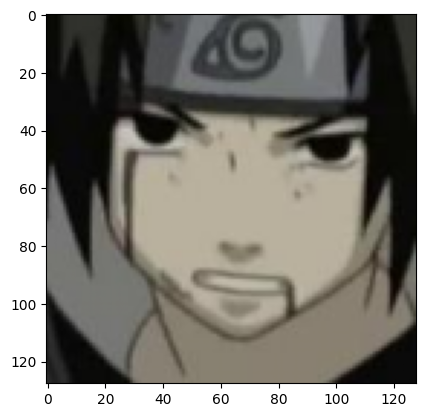

In [197]:
plt.imshow(transformed_dataset[0].permute(1,2,0))